In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import random
from tqdm import tqdm
import seaborn as sns

In [2]:
class TicTacToe:
    def __init__(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1  # Player 1 starts
        self.game_over = False
        self.winner = None
        
    def reset(self):
        self.board = np.zeros((3, 3), dtype=int)
        self.current_player = 1
        self.game_over = False
        self.winner = None
        return self.get_state()
    
    def get_state(self):
        # Flatten the board and convert to tuple for hashability
        return tuple(self.board.flatten())
    
    def get_available_actions(self):
        return [(i, j) for i in range(3) for j in range(3) if self.board[i, j] == 0]
    
    def make_move(self, action):
        i, j = action
        if self.board[i, j] != 0:
            return False  # Invalid move
            
        self.board[i, j] = self.current_player
        
        # Check for win
        if self.check_win(self.current_player):
            self.game_over = True
            self.winner = self.current_player
            return True
            
        # Check for draw
        if len(self.get_available_actions()) == 0:
            self.game_over = True
            return True
            
        # Switch player
        self.current_player = 3 - self.current_player  # Switches between 1 and 2
        return True
    
    def check_win(self, player):
        # Check rows and columns
        for i in range(3):
            if all(self.board[i, :] == player) or all(self.board[:, i] == player):
                return True
        # Check diagonals
        if (self.board[0, 0] == self.board[1, 1] == self.board[2, 2] == player) or \
           (self.board[0, 2] == self.board[1, 1] == self.board[2, 0] == player):
            return True
        return False

In [3]:
class QLearningAgent:
    def __init__(self, player, learning_rate=0.1, discount_factor=0.9, exploration_rate=1.0, 
                 exploration_decay=0.9995, min_exploration=0.01):
        self.player = player
        self.q_table = defaultdict(lambda: np.zeros((3, 3)))
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate
        self.exploration_decay = exploration_decay
        self.min_exploration = min_exploration
        self.training_history = {'wins': [], 'losses': [], 'draws': [], 'exploration': []}
        
    def get_action(self, state, available_actions):
        state_board = np.array(state).reshape(3, 3)
        
        if random.random() < self.exploration_rate:
            # Exploration: random action
            return random.choice(available_actions)
        else:
            # Exploitation: best action from Q-table
            q_values = self.q_table[state]
            # Mask invalid actions with -inf
            masked_q = np.where(state_board == 0, q_values, -np.inf)
            # Get the index of the maximum value
            flat_idx = np.argmax(masked_q)
            return (flat_idx // 3, flat_idx % 3)
    
    def update_q_table(self, state, action, reward, next_state, done):
        state_board = np.array(state).reshape(3, 3)
        next_state_board = np.array(next_state).reshape(3, 3) if next_state is not None else None
        
        current_q = self.q_table[state][action[0], action[1]]
        
        if done:
            max_next_q = 0
        else:
            if next_state_board is not None:
                # Mask invalid actions for next state
                masked_q = np.where(next_state_board == 0, self.q_table[next_state], -np.inf)
                max_next_q = np.max(masked_q)
            else:
                max_next_q = 0
        
        # Q-learning update
        new_q = current_q + self.learning_rate * (reward + self.discount_factor * max_next_q - current_q)
        self.q_table[state][action[0], action[1]] = new_q
    
    def decay_exploration(self):
        self.exploration_rate = max(self.min_exploration, self.exploration_rate * self.exploration_decay)
    
    def record_result(self, result):
        if result == self.player:
            self.training_history['wins'].append(1)
            self.training_history['losses'].append(0)
            self.training_history['draws'].append(0)
        elif result == 0:
            self.training_history['wins'].append(0)
            self.training_history['losses'].append(0)
            self.training_history['draws'].append(1)
        else:
            self.training_history['wins'].append(0)
            self.training_history['losses'].append(1)
            self.training_history['draws'].append(0)
        self.training_history['exploration'].append(self.exploration_rate)

In [4]:
def train_agents(episodes=50000):
    env = TicTacToe()
    agent1 = QLearningAgent(player=1)  # X (starts first)
    agent2 = QLearningAgent(player=2)  # O (starts second)
    
    with tqdm(total=episodes, desc="Training agents") as pbar:
        for episode in range(episodes):
            # Alternate starting player each episode
            starting_player = 1 if episode % 2 == 0 else 2
            env.current_player = starting_player
            
            state = env.reset()
            done = False
            move_history = []
            
            while not done:
                current_agent = agent1 if env.current_player == 1 else agent2
                available_actions = env.get_available_actions()
                
                if not available_actions:
                    break
                    
                action = current_agent.get_action(state, available_actions)
                move_history.append((current_agent, state, action))
                env.make_move(action)
                next_state = env.get_state()
                
                if env.game_over:
                    done = True
                    # Assign rewards based on outcome
                    if env.winner == 1:
                        reward1, reward2 = 1, -1
                    elif env.winner == 2:
                        reward1, reward2 = -1, 1
                    else:
                        reward1, reward2 = 0.5, 0.5  # Draw
                    
                    # Update both agents' Q-tables
                    for agent, s, a in move_history:
                        reward = reward1 if agent.player == 1 else reward2
                        agent.update_q_table(s, a, reward, None, True)
                    
                    # Record results
                    agent1.record_result(env.winner)
                    agent2.record_result(env.winner)
                else:
                    state = next_state
            
            # Decay exploration after each episode
            agent1.decay_exploration()
            agent2.decay_exploration()
            pbar.update(1)
    
    return agent1, agent2

In [5]:
def plot_training_results(agent1, agent2):
    # Smoothing function
    def smooth(data, window_size=1000):
        return np.convolve(data, np.ones(window_size)/window_size, mode='valid')
    
    # Create dashboard figure
    plt.figure(figsize=(18, 12))
    
    # First row - two columns
    # Win rates plot (left)
    ax1 = plt.subplot2grid((2, 2), (0, 0))
    episodes = len(agent1.training_history['wins'])
    x_smooth = np.arange(len(smooth(agent1.training_history['wins'])))
    
    ax1.plot(x_smooth, smooth(agent1.training_history['wins']), 
            label='Agent 1 (X) Wins', color='tab:blue', linewidth=2)
    ax1.plot(x_smooth, smooth(agent2.training_history['wins']), 
            label='Agent 2 (O) Wins', color='tab:red', linewidth=2)
    ax1.plot(x_smooth, smooth(agent1.training_history['draws']), 
            label='Draws', color='tab:orange', linewidth=2)
    
    ax1.set_title('Win/Draw Rates During Training', fontsize=14)
    ax1.set_xlabel('Episode (smoothed)')
    ax1.set_ylabel('Rate')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.5)
    
    # Exploration rate plot (right)
    ax2 = plt.subplot2grid((2, 2), (0, 1))
    ax2.plot(agent1.training_history['exploration'], 
             label='Agent 1 Exploration', color='blue', linestyle='-', linewidth=1)  # Bold line
    ax2.plot(agent2.training_history['exploration'], 
             label='Agent 2 Exploration', color='red', linestyle='--', linewidth=2)
    ax2.set_title('Exploration Rate Decay')
    ax2.set_xlabel('Episode')
    ax2.set_ylabel('Exploration Rate')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.5)
    
    # Second row - full width final performance
    ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)
    last_n = 5000
    labels = ['Agent 1 Wins', 'Agent 2 Wins', 'Draws']
    values = [
        np.sum(agent1.training_history['wins'][-last_n:]),
        np.sum(agent2.training_history['wins'][-last_n:]),
        np.sum(agent1.training_history['draws'][-last_n:])
    ]
    bars = ax3.bar(labels, values, color=['tab:blue', 'tab:red', 'tab:orange'])
    
    # Add value annotations
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom')
    
    ax3.set_title(f'Final Performance (last {last_n} episodes - Absolute Counts)')
    ax3.set_ylabel('Number of Games')
    ax3.grid(True, linestyle='--', alpha=0.5, axis='y')
    
    plt.tight_layout()
    plt.show()

In [6]:
def test_trained_agents(agent1, agent2, games=1000):
    env = TicTacToe()
    results = {'agent1_wins': 0, 'agent2_wins': 0, 'draws': 0}
    
    with tqdm(total=games, desc="Testing agents") as pbar:
        for _ in range(games):
            state = env.reset()
            done = False
            
            while not done:
                current_agent = agent1 if env.current_player == 1 else agent2
                available_actions = env.get_available_actions()
                
                if not available_actions:
                    break
                    
                action = current_agent.get_action(state, available_actions)
                env.make_move(action)
                state = env.get_state()
                
                if env.game_over:
                    if env.winner == 1:
                        results['agent1_wins'] += 1
                    elif env.winner == 2:
                        results['agent2_wins'] += 1
                    else:
                        results['draws'] += 1
                    break
            pbar.update(1)
    
    # Create dashboard-style plot
    plt.figure(figsize=(18, 6))
    
    labels = ['Agent 1 Wins', 'Agent 2 Wins', 'Draws']
    values = [results['agent1_wins'], results['agent2_wins'], results['draws']]
    bars = plt.bar(labels, values, color=['tab:blue', 'tab:red', 'tab:orange'])
    
    # Add annotations
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f"{int(height)}",
                ha='center', va='bottom', fontsize=12)
    
    plt.title(f'Trained Agents Competition Results ({games} games)', fontsize=14)
    plt.ylabel('Number of Games')
    plt.grid(True, linestyle='--', alpha=0.5, axis='y')
    
    plt.show()
    
    return results

In [7]:
def plot_agent_heatmaps(agent1, agent2):
    """Plot heatmaps showing learned move preferences"""
    # Collect move preferences weighted by Q-values
    move_weights1 = np.zeros((3, 3))
    move_weights2 = np.zeros((3, 3))
    
    for state in list(agent1.q_table.keys())[:10000]:  # Sample states
        state_board = np.array(state).reshape(3, 3)
        available = [(i,j) for i in range(3) for j in range(3) if state_board[i,j] == 0]
        
        if available:
            # Agent 1 - weight by Q-values
            q1 = agent1.q_table[state]
            for i,j in available:
                move_weights1[i,j] += q1[i,j]
            
            # Agent 2 - weight by Q-values with exploration boost
            q2 = agent2.q_table[state]
            if np.allclose(q2, q2[0,0]):  # If no preferences learned
                # Distribute weight evenly among available moves
                for i,j in available:
                    move_weights2[i,j] += 1/len(available)
            else:
                for i,j in available:
                    move_weights2[i,j] += q2[i,j]
    
    # Normalize to probabilities
    def normalize(m):
        m = m - np.min(m)  # Shift to positive
        return m/np.sum(m) if np.sum(m) > 0 else m
    
    move_probs1 = normalize(move_weights1)
    move_probs2 = normalize(move_weights2)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14,6))
    fig.suptitle('Learned Move Preferences (Weighted by Q-values)', fontsize=14, y=1.05)
    
    # Agent 1 heatmap
    sns.heatmap(move_probs1, annot=True, fmt=".2f", cmap="Blues", 
                cbar=False, square=True, ax=ax1, vmin=0, vmax=0.5)
    ax1.set_title('Agent 1 (X) - Best Learned Moves')
    ax1.set_xticklabels([1,2,3])
    ax1.set_yticklabels(['A','B','C'])
    
    # Agent 2 heatmap
    sns.heatmap(move_probs2, annot=True, fmt=".2f", cmap="Reds", 
                cbar=False, square=True, ax=ax2, vmin=0, vmax=0.5)
    ax2.set_title('Agent 2 (O) - Best Learned Moves') 
    ax2.set_xticklabels([1,2,3])
    ax2.set_yticklabels(['A','B','C'])
    
    plt.tight_layout()
    plt.show()

Training Q-learning agents for Tic-Tac-Toe...


Training agents: 100%|██████████| 50000/50000 [00:20<00:00, 2467.15it/s]



Plotting training results...


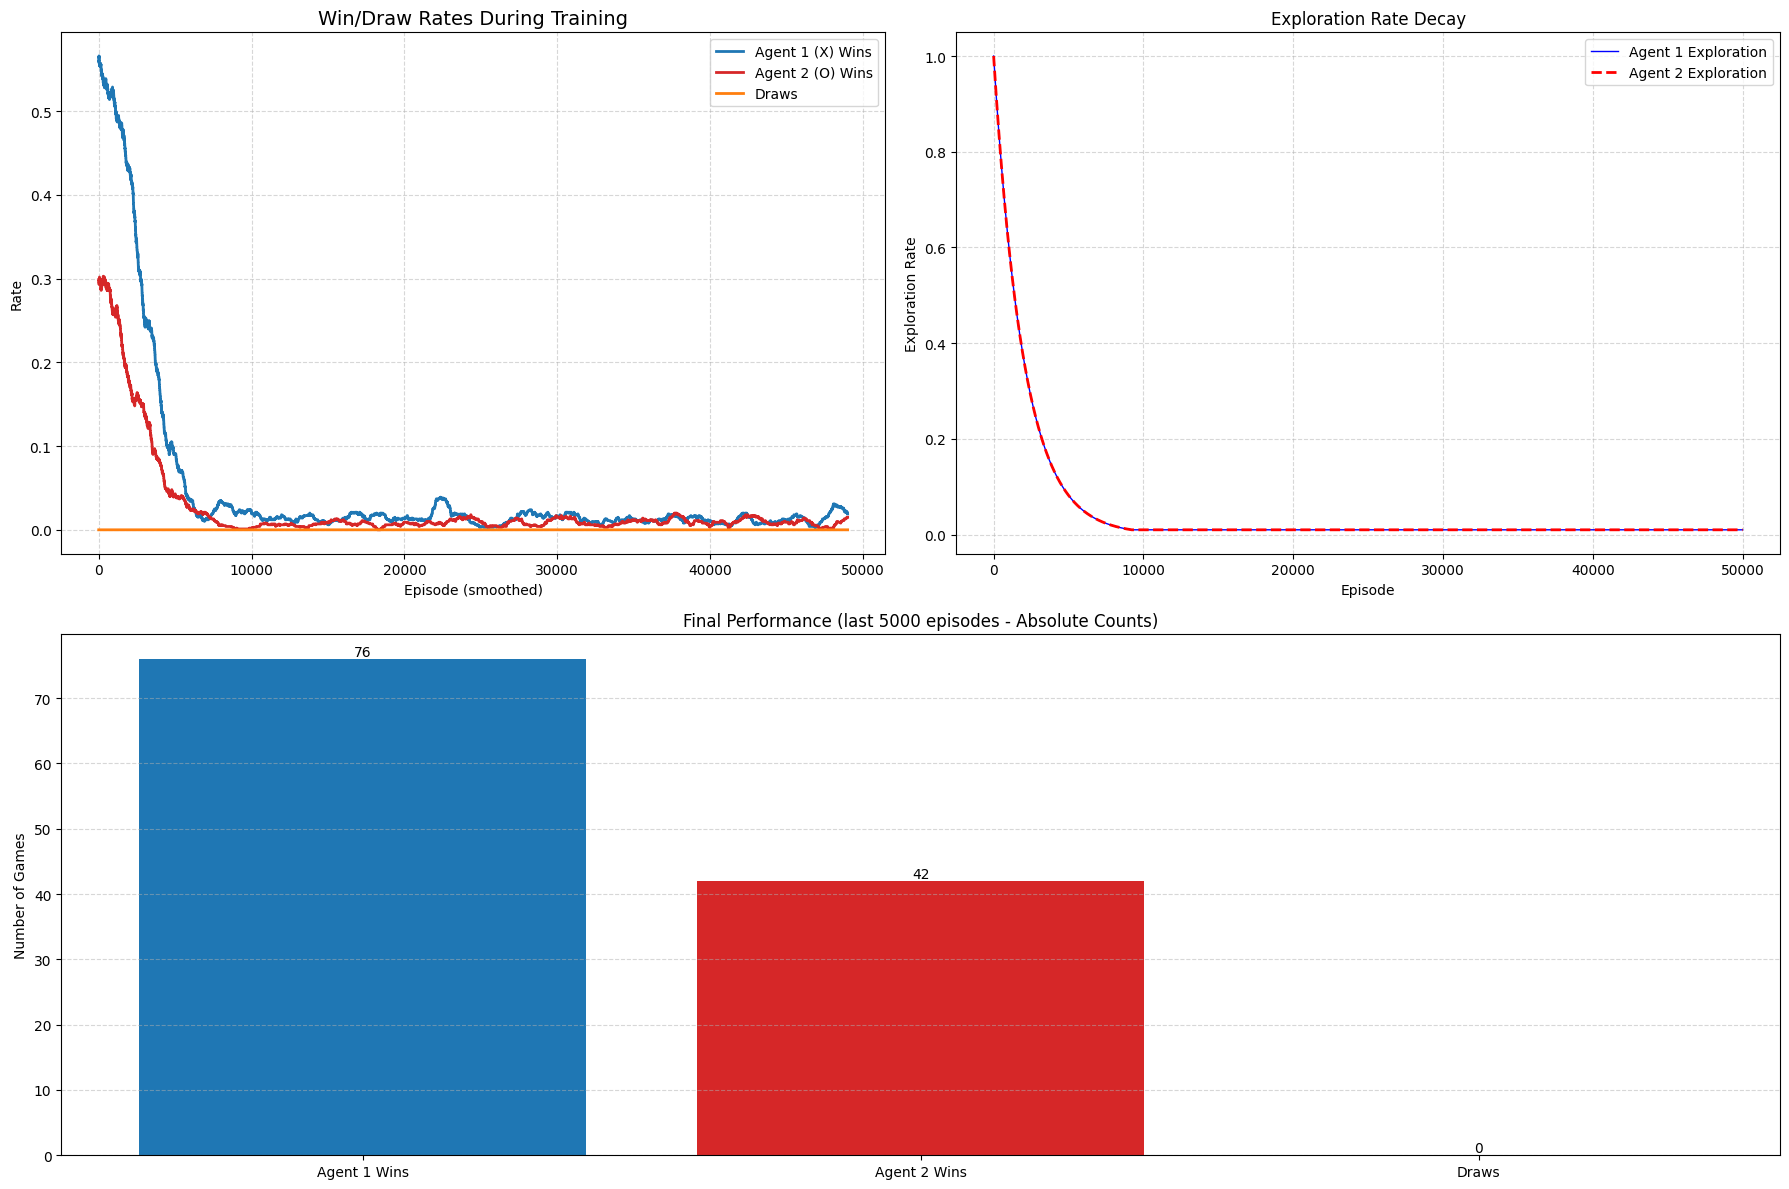

In [46]:
print("Training Q-learning agents for Tic-Tac-Toe...")
agent1, agent2 = train_agents(episodes=50000)

print("\nPlotting training results...")
plot_training_results(agent1, agent2)


Plotting agent move preferences...


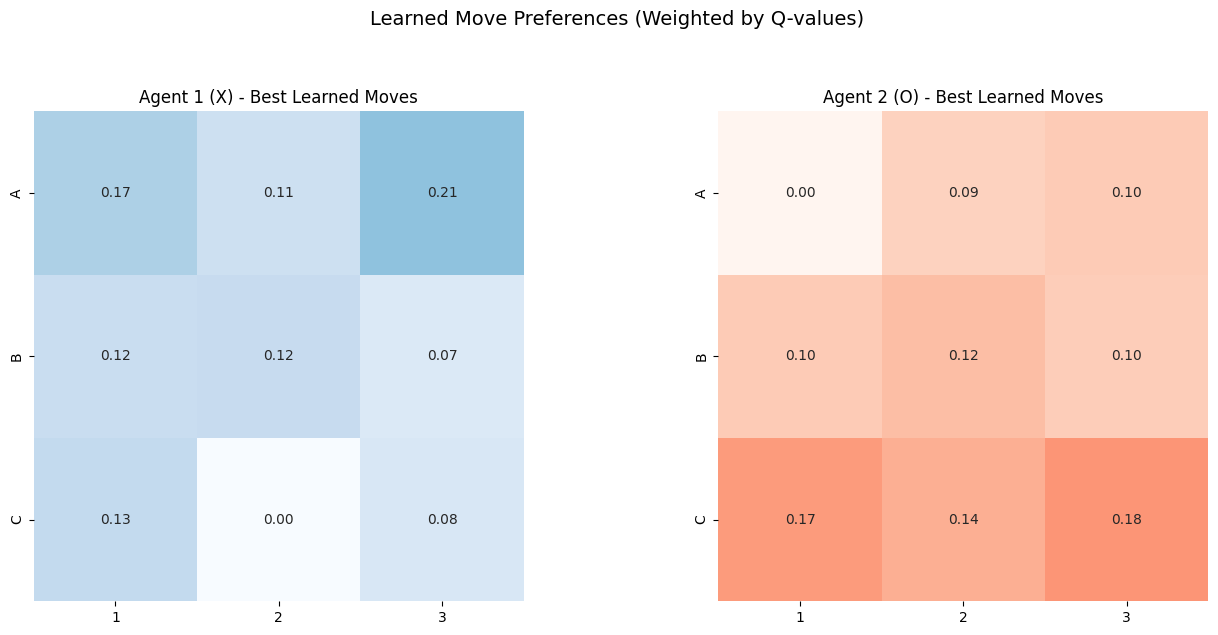

In [54]:
print("\nPlotting agent move preferences...")
plot_agent_heatmaps(agent1, agent2)


Testing trained agents against each other...


Testing agents: 100%|██████████| 1000/1000 [00:00<00:00, 2301.63it/s]


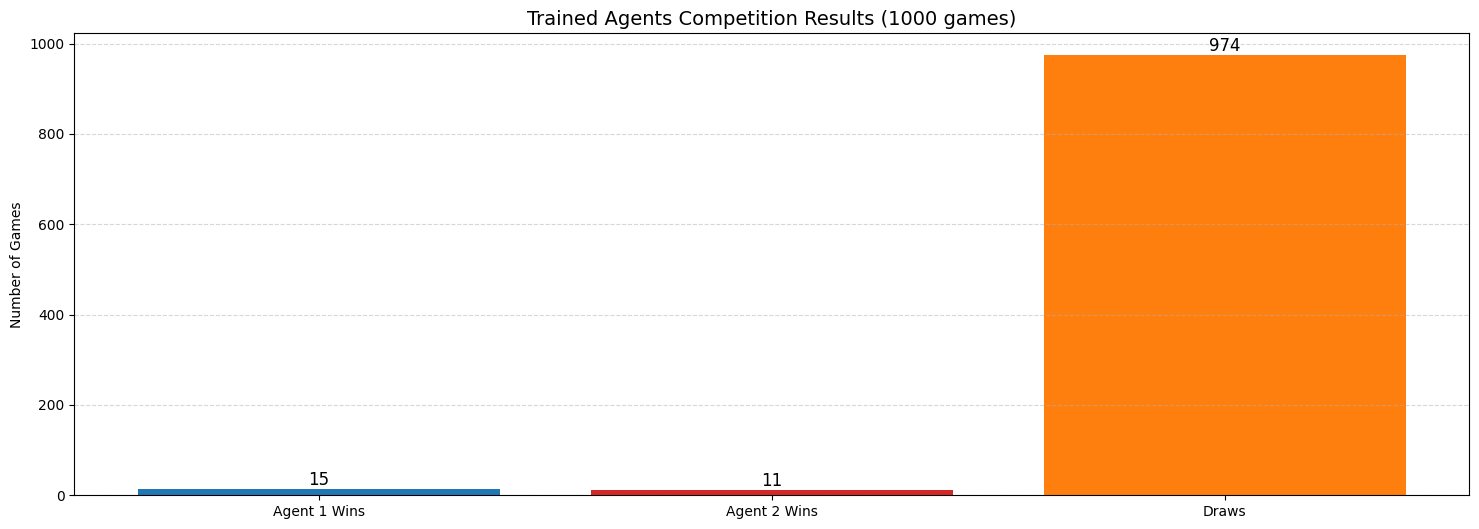


Final Test Results:
Agent 1 (X) wins: 15 (1.5%)
Agent 2 (O) wins: 11 (1.1%)
Draws: 974 (97.4%)


In [48]:
print("\nTesting trained agents against each other...")
test_results = test_trained_agents(agent1, agent2, games=1000)
print("\nFinal Test Results:")
print(f"Agent 1 (X) wins: {test_results['agent1_wins']} ({test_results['agent1_wins']/10:.1f}%)")
print(f"Agent 2 (O) wins: {test_results['agent2_wins']} ({test_results['agent2_wins']/10:.1f}%)")
print(f"Draws: {test_results['draws']} ({test_results['draws']/10:.1f}%)")